### IMPORTS

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.models
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from data_preparation import get_imgs_directory, resize_and_save_img_in_directory, get_datasets, get_img_num

### DATA PREPARATION

In [4]:
target_size = (256, 256)
burst_image_dir, nburst_image_dir = get_imgs_directory()

c:\Users\bbaki\Desktop\fhnw\Scripts\radio_sunburst_detector\data\burst
c:\Users\bbaki\Desktop\fhnw\Scripts\radio_sunburst_detector\data\no_burst


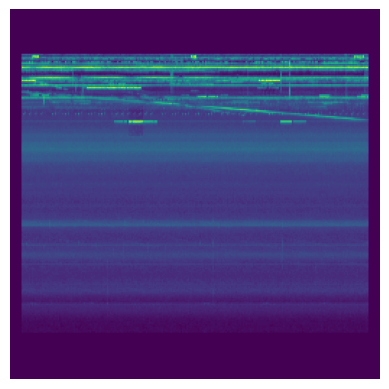

In [5]:
resize_and_save_img_in_directory(burst_image_dir, target_size)

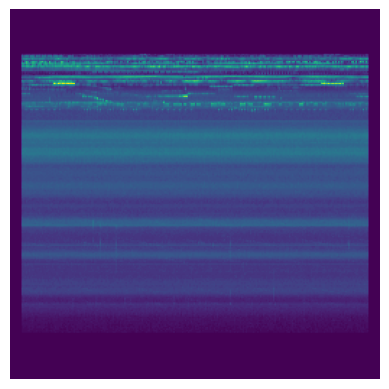

In [6]:
resize_and_save_img_in_directory(nburst_image_dir, target_size)

In [7]:
train_ds, validation_ds = get_datasets()

Found 1999 files belonging to 2 classes.
Using 1600 files for training.
Found 1999 files belonging to 2 classes.
Using 399 files for validation.


In [6]:
train_total_size = get_img_num(train_ds)
val_total_size = get_img_num(validation_ds)

print("Training data Image number: ", train_total_size)
print("Validation data Image number: ", val_total_size)

Training data Image number:  3
Validation data Image number:  1


### MODEL IMPLEMENTATION

In [15]:
#Fix the random generator seeds for better reproducibility
tf.random.set_seed(67)
np.random.seed(67)

In [16]:
#Class to build the Model
class Model_builder:
        def __init__(self, input_shape, num_classes):
            self.input_shape = input_shape
            self.num_classes = num_classes
            self.model = None
        def build(self):

            input_img = Input(shape=self.input_shape)
            x= input_img
            # AUTOENCODER
            for _ in range(3):
                x = Conv2D(
                    filters=3,
                    kernel_size=3, #could be changed 
                    activation='relu',
                    padding='same',
                    activity_regularizer=regularizers.l1(0.00001),
                    kernel_initializer='he_normal'
                )(x)
                x = MaxPooling2D((2, 2), padding='same')(x) #max pooling layer

            #max pooling layer to give us the result of the encoding process: latent space
            x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
            encoded = Conv2D(3, (1, 1), activation='relu')(x)
            print(encoded.shape)

            #MODEL1   
            x = tf.keras.layers.Flatten()(encoded)
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            output = tf.keras.layers.Dense(1, activation='sigmoid')(x)   
             
             
                        #MODEL2   
                        #flattened = tf.keras.layers.Flatten()(encoded)
                        #dense_1 = tf.keras.layers.Dense(1000, activation='relu')(flattened)
                        #dense_2 = tf.keras.layers.Dense(100, activation='relu')(dense_1)
                        #output = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)
                   
                        
                        #start of decoding, remove comment for decoding
                        #x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
                        #x = UpSampling2D((2, 2))(x)
                        #x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
                        #x = UpSampling2D((2, 2))(x)
                        #decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

            
            #create the model using keras Model function with all the earlier configuration and return it
            self.model = tf.keras.models.Model(inputs=input_img, outputs=output)
 
        #compile the model
        def compile(self):
            self.model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy']
            )
            return self.model
            
        

In [17]:
#Create a model_builder object, build and compile the model inside it and retrieve it as "model"
model_builder_object = Model_builder(input_shape=(256, 256, 1) ,num_classes=2)#this part can be replaced with correct input shape: 
model_builder_object.build() 
model = model_builder_object.compile()
 


(None, 32, 32, 3)


In [18]:
#Train the model
model.fit(
    train_ds,
    validation_data=(validation_ds),
    epochs=20,
    batch_size=32,
)

Epoch 1/20


3/3 [==============================] - 3s 444ms/step - loss: 0.8337 - accuracy: 0.6000 - val_loss: 0.8514 - val_accuracy: 0.4500
Epoch 2/20
3/3 [==============================] - 1s 295ms/step - loss: 0.8114 - accuracy: 0.5625 - val_loss: 0.8085 - val_accuracy: 0.5500
Epoch 3/20
3/3 [==============================] - 1s 276ms/step - loss: 0.8057 - accuracy: 0.5875 - val_loss: 0.8093 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 1s 264ms/step - loss: 0.7696 - accuracy: 0.6625 - val_loss: 0.7942 - val_accuracy: 0.5500
Epoch 5/20
3/3 [==============================] - 1s 275ms/step - loss: 0.7605 - accuracy: 0.6000 - val_loss: 0.7777 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 1s 266ms/step - loss: 0.7375 - accuracy: 0.6250 - val_loss: 0.7605 - val_accuracy: 0.7500
Epoch 7/20
3/3 [==============================] - 1s 278ms/step - loss: 0.7299 - accuracy: 0.7125 - val_loss: 0.7502 - val_accuracy: 0.7500
Epoch 8/20
3/3 [===============